# **Free GPU Memory**

In [1]:
!pip install numba 
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
!nvidia-smi

Mon Jul 19 18:01:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W /  70W |      3MiB / 15109MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# ***Download Data and Import LIBs***

In [3]:
!curl -L -o "text.txt" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter01/text.txt"
# For Language Acceptance
!curl -L -o "in_domain_train.tsv" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter02/in_domain_train.tsv"
!curl -L -o "out_of_domain_dev.tsv" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter02/out_of_domain_dev.tsv"
# Kant 
!curl -L -o "kant.txt" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter03/kant.txt"

# OpenAi GPT2
!curl -L -o "accumulate.py" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter06/gpt-2-train_files/accumulate.py"
!curl -L -o "dset.txt" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter06/gpt-2-train_files/dset.txt"
!curl -L -o "encode.py" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter06/gpt-2-train_files/encode.py"
!curl -L -o "load_dataset.py" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter06/gpt-2-train_files/load_dataset.py"
!curl -L -o "memory_saving_gradients.py" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter06/gpt-2-train_files/memory_saving_gradients.py"
!curl -L -o "train.py" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter06/gpt-2-train_files/train.py"
!curl -L -o "mdset.txt" "https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter08/gpt-2-train_files/mdset.txt"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24151  100 24151    0     0  91481      0 --:--:-- --:--:-- --:--:-- 91481
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1622k      0 --:--:-- --:--:-- --:--:-- 1616k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   111k      0 --:--:-- --:--:-- --:--:--  111k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.7M  100 10.7M    0     0  10.1M      0  0:00:01  0:00:01 --:--:-- 10.1M
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
!pip install gensim==3.8.3
!pip install -q transformers
!pip install toposort
!pip install sentencepiece
!pip install allennlp==1.0.0 allennlp-models==1.0.0 # for SRL

     |████████████████████████████████| 24.2 MB 87 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 2.5 MB 8.3 MB/s 
     |████████████████████████████████| 895 kB 56.1 MB/s 
     |████████████████████████████████| 3.3 MB 59.6 MB/s 
     |████████████████████████████████| 1.2 MB 7.5 MB/s 
     |████████████████████████████████| 473 kB 7.6 MB/s 
     |████████████████████████████████| 282 kB 42.5 MB/s 
     |████████████████████████████████| 753.2 MB 10 kB/s 
     |████████████████████████████████| 259 kB 64.4 MB/s 
     |████████████████████████████████| 674 kB 50.5 MB/s 
     |████████████████████████████████| 124 kB 73.7 MB/s 
     |████████████████████████████████| 131 kB 73.0 MB/s 
     |████████████████████████████████| 56 kB 6.5 MB/s 
     |████████████████████████████████| 5.6 MB 32.5 MB/s 
     |████████████████████████████████| 79

In [5]:
import nltk
import tensorflow as tf 
import math
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertTokenizer, BertConfig,AdamW, TFBertForSequenceClassification, get_linear_schedule_with_warmup, BertModel
#for Section 2
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from transformers import RobertaTokenizer,RobertaConfig , RobertaForMaskedLM
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling,Trainer, TrainingArguments, pipeline
#for text summ section
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

from pathlib import Path
from tqdm import tqdm , trange
import pandas as pd
import io 
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import os
import json


warnings.filterwarnings(action = 'ignore') 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Skip Gram Model**

In [ ]:
# load Data
data = open('text.txt', 'r')
data = data.read()

In [ ]:
data = data.replace('\n', ' ')

In [ ]:
tokinized_data = []
for sent in sent_tokenize(data):
  temp = []
  for word in word_tokenize(sent):
    temp.append(word.lower())
  tokinized_data.append(temp)


In [ ]:
model= gensim.models.Word2Vec(tokinized_data,min_count= 1 , size = 512,sg=1 ,window=5)
model.save('w2v.model')

In [ ]:
model = gensim.models.Word2Vec.load('/content/w2v.model')

In [ ]:
model.wv['cat']

In [ ]:
# 1-The 2-black 3-cat 4-sat 5-on 6-the 7-couch 8-and 9-the 10-brown 11-dog 12-slept 13-on 14-the 15-rug.
word1='black'
word2='brown'
pos1=2
pos2=10
a=model[word1]
b=model[word2]

In [ ]:
a = a.reshape(1,512)
b = b.reshape(1,512)
cosine_similarity(a,b)

array([[0.9998787]], dtype=float32)

# **BERT - Fine Tuning**
using bidirectional - no decoder phase

In [ ]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

### Load Dataset

In [ ]:
df = pd.read_csv('in_domain_train.tsv',sep = '\t',header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


### Creating sentences, label lists, and adding BERT tokens

In [ ]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values
labels = df.label.values

In [ ]:
# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + "[SEP]" for sentence in sentences]


In [ ]:
sentences[:4]

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose .[SEP]",
 "[CLS] one more pseudo generalization and i 'm giving up .[SEP]",
 "[CLS] one more pseudo generalization or i 'm giving up .[SEP]",
 '[CLS] the more we study verbs , the crazier they get .[SEP]']

In [ ]:
# Bert Tokenizer
# Init Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased' , do_lower_case= True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


In [ ]:
print(tokenized_texts[0])

['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [ ]:
MAX_LEN = 128 # Original Paper use 512 


#######Pad Sequences [Not Used]
input_ids = [tokenizer.convert_tokens_to_ids(token) for token in tokenized_texts]
input_ids = pad_sequences(input_ids , MAX_LEN,dtype= 'long' , padding = 'post' ,truncating='post')

### Creating MASKS [Not Used]

We padded the sequences in the previous
cell. But we want to prevent the model from performing attention on those padded
tokens!
The idea is to apply a mask with a value of 1 for each token, which will be followed
by 0s for padding:

attention_masks = []

Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[1])

### Splitting data into training and validation

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(sentences, labels, random_state=2018, test_size=0.1)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test)))

### Selecting a batch size and creating an iterator


### Create an iterator of our data with torch DataLoader. 
This helps save
on memory during training because, unlike a for loop,
with an iterator the entire dataset does not need to be loaded into
memory


In [ ]:
BATCH_SIZE = 32 # Recommend 16 or 32

## BERT model configuration

In [ ]:
configuration = BertConfig()
model = BertModel(configuration)
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



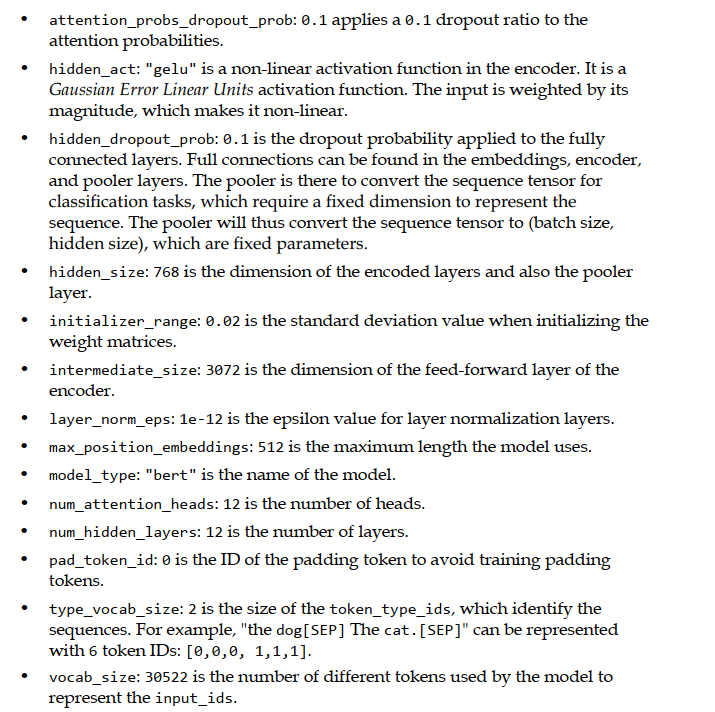

## Loading the Hugging Face BERT uncased base model

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [ ]:
N_EPOCHS =4 
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions. 
model.compile(optimizer=optimizerr,                                     
              loss=losss,
              metrics=['accuracy'])

model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE), 
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Epoch 1/4
241/241 [==============================] - 114s 415ms/step - loss: 0.5049 - accuracy: 0.7592
Epoch 2/4
241/241 [==============================] - 100s 415ms/step - loss: 0.3017 - accuracy: 0.8764
Epoch 3/4
241/241 [==============================] - 100s 416ms/step - loss: 0.1787 - accuracy: 0.9328
Epoch 4/4
241/241 [==============================] - 100s 415ms/step - loss: 0.1158 - accuracy: 0.9611


## Training Evaluation

In [ ]:
model.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

27/27 [==============================] - 6s 130ms/step - loss: 0.6510 - accuracy: 0.8061


{'accuracy': 0.8060747385025024, 'loss': 0.6509996652603149}

## Predict on the different text examples

In [ ]:
def predict_proba(text_list, model=model, tokenizer=tokenizer):
  """
  To get array with predicted probabilities for 0 - instructions, 1- ingredients classes 
  for each paragraph in the list of strings
  :param text_list: list[str]
  :param model: transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification
  :param tokenizer: transformers.models.distilbert.tokenization_distilbert.DistilBertTokenizer
  :return res: numpy.ndarray
  """
     
  encodings = tokenizer(text_list, max_length=MAX_LEN, truncation=True, padding=True)
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 
  preds = model.predict(dataset.batch(1)).logits
  res = tf.nn.softmax(preds, axis=1).numpy()
    
  return np.argmax(res)

In [ ]:
print(predict_proba(['peter have good'], model,tokenizer)) #Wrong Grammer
print(predict_proba(['my name is peter'], model,tokenizer)) #Acceptable Grammer

0
1


## Evaluating using Matthews Correlation Coefficient

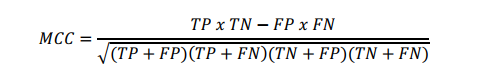

The value produced by MCC is between -1 and +1. +1 is the maximum positive value
of a prediction. -1 is an inverse prediction. 0 is an average random prediction.

In [ ]:
pred_labels = [predict_proba([x]) for x in X_test]

In [ ]:
matthews_corrcoef(y_test, pred_labels)


0.5194672936972929

# **Pretraining a RoBERTa Model from Scratch [Pytorch]**
##  train a new language model from scratch 
no pretrained tokenizers or models will be used,
it does not use WordPiece
tokenization but goes down to byte-level Byte Pair Encoding (BPE)
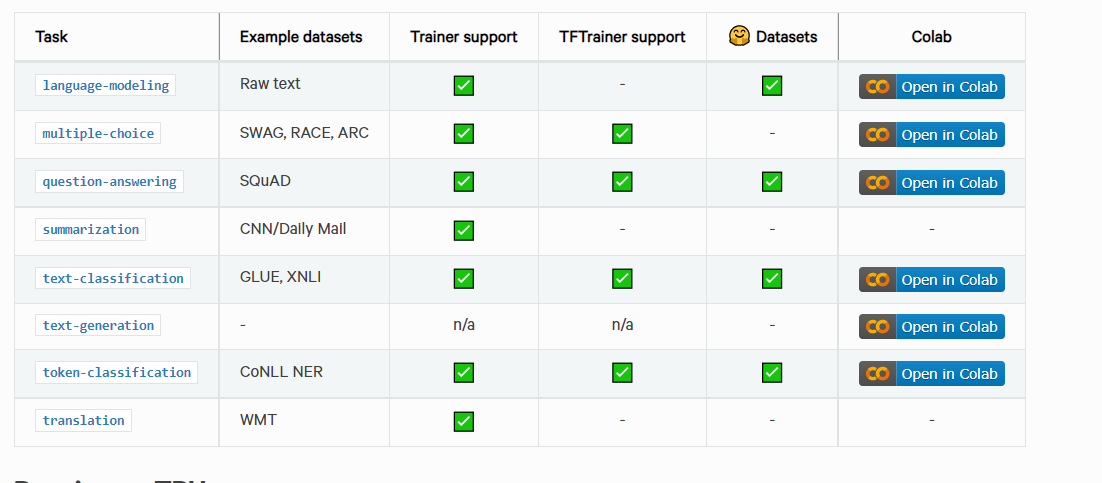

## Train Tokenizer

In [ ]:
paths = [str(x) for x in Path(".").glob("**/*.txt")]
paths


['kant.txt', 'text.txt']

In [ ]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=['kant.txt'], vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

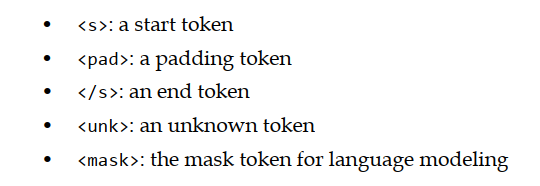

## Saving the Tokenizer to disk

In [ ]:
tok_path= './KantaiBERT'
if not os.path.exists(tok_path):
  os.makedirs(tok_path)
tokenizer.save_model(tok_path)

['./KantaiBERT/vocab.json', './KantaiBERT/merges.txt']

## Loading the Tokenizer to Memory

In [ ]:
tokenizer = ByteLevelBPETokenizer('/content/KantaiBERT/vocab.json', # load Vocab First
                                  '/content/KantaiBERT/merges.txt')

In [ ]:
tokenizer.encode("The Critique of Pure Reason.").tokens


['The', 'ĠCritique', 'Ġof', 'ĠPure', 'ĠReason', '.']

In [ ]:
tokenizer.encode("The Critique of Pure Reason.")


Encoding(num_tokens=6, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

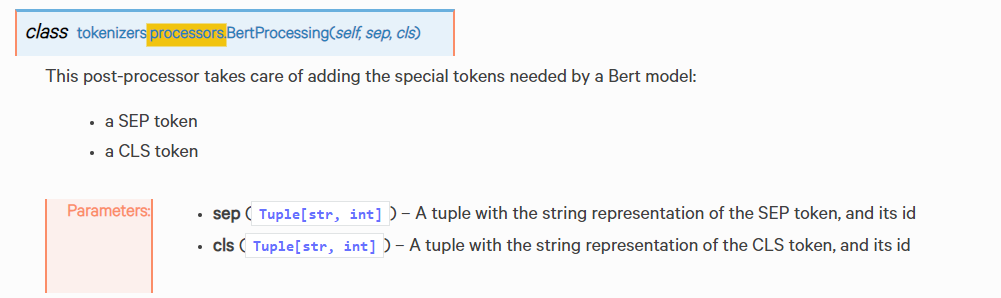

In [ ]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)


In [ ]:
tokenizer.encode("The Critique of Pure Reason.").tokens


['<s>', 'The', 'ĠCritique', 'Ġof', 'ĠPure', 'ĠReason', '.', '</s>']

## Model Configuration

In [ ]:
config = RobertaConfig(vocab_size=52_000,
max_position_embeddings=514,
num_attention_heads=12,
num_hidden_layers=6,
type_vocab_size=1)
print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



## Reloading the tokenizer in transformers

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('./KantaiBERT' , max_length = 512,)

## Initializing a model from scratch

In [ ]:
model = RobertaForMaskedLM(config,)

In [ ]:
model.config

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

In [ ]:
model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

## Building the dataset

In [ ]:
dataset = LineByLineTextDataset(
  tokenizer=tokenizer,
  file_path="./kant.txt",
  block_size=128,
  )

### Defining a data collator
We need to run a data collator before initializing the trainer. A data collator will take

samples from the dataset and collate them into batches. The results are dictionarylike objects.
We are preparing a batched sample process for Masked Language Modeling (MLM)
by setting mlm=True.

We also set the number of masked tokens to train mlm_probability=0.15. This will
determine the percentage of tokens masked during the pretraining process.

We now initialize data_collator with our tokenizer, MLM activated, and the
proportion of masked tokens set to 0.15

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

### Initializing the trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./KantaiBERT",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

## Train Model

In [ ]:
%%time
trainer.train()

***** Running training *****
  Num examples = 170964
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2672


Step,Training Loss
500,6.607600
1000,5.765300
1500,5.292000
2000,5.027200
2500,4.874400




Training completed. Do not forget to share your model on huggingface.co/models =)




CPU times: user 10min 7s, sys: 2.54 s, total: 10min 10s
Wall time: 10min 11s


TrainOutput(global_step=2672, training_loss=5.4691258276294095, metrics={'train_runtime': 611.602, 'train_samples_per_second': 279.535, 'train_steps_per_second': 4.369, 'total_flos': 1689743923455744.0, 'train_loss': 5.4691258276294095, 'epoch': 1.0})

## Saving the final model (+tokenizer + config) to disk

In [ ]:
trainer.save_model("./KantaiBERT")

Saving model checkpoint to ./KantaiBERT
Configuration saved in ./KantaiBERT/config.json
Model weights saved in ./KantaiBERT/pytorch_model.bin


## Language modeling with FillMaskPipeline
We will use our trained
model and trained tokenizer to perform masked language modeling

In [ ]:
fill_mask = pipeline(
"fill-mask",
model="./KantaiBERT",
tokenizer="./KantaiBERT"
)

loading configuration file ./KantaiBERT/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading configuration file ./KantaiBERT/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hid

In [ ]:
fill_mask("Human thinking involves human <mask>.")


[{'score': 0.0349540188908577,
  'sequence': 'Human thinking involves human reason.',
  'token': 393,
  'token_str': ' reason'},
 {'score': 0.013035155832767487,
  'sequence': 'Human thinking involves human object.',
  'token': 394,
  'token_str': ' object'},
 {'score': 0.010148422792553902,
  'sequence': 'Human thinking involves human law.',
  'token': 446,
  'token_str': ' law'},
 {'score': 0.009281916543841362,
  'sequence': 'Human thinking involves human experience.',
  'token': 531,
  'token_str': ' experience'},
 {'score': 0.007839045487344265,
  'sequence': 'Human thinking involves human is.',
  'token': 300,
  'token_str': ' is'}]

# BLEU For Translation

In [ ]:

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

#Example 1
reference = [['the', 'cat', 'likes', 'milk'], ['cat', 'likes' 'milk']]
candidate = ['the', 'cat', 'likes', 'milk']
score = sentence_bleu(reference, candidate)
print('Example 1', score)

#Example 2
reference = [['the', 'cat', 'likes', 'milk']]
candidate = ['the', 'cat', 'likes', 'milk']
score = sentence_bleu(reference, candidate)
print('Example 2', score)

#Example 3
reference = [['the', 'cat', 'likes', 'milk']]
candidate = ['the', 'cat', 'enjoys','milk']
score = sentence_bleu(reference, candidate)
print('Example 3', score)


#Example 4
reference = [['je','vous','invite', 'a', 'vous', 'lever','pour', 'cette', 'minute', 'de', 'silence']]
candidate = ['levez','vous','svp','pour', 'cette', 'minute', 'de', 'silence']
score = sentence_bleu(reference, candidate)
print("without soothing score", score)

chencherry = SmoothingFunction()
r1=list('je vous invite a vous lever pour cette minute de silence')
candidate=list('levez vous svp pour cette minute de silence')
        
#sentence_bleu([reference1, reference2, reference3], hypothesis2,smoothing_function=chencherry.method1)
print("with smoothing score",sentence_bleu([r1], candidate,smoothing_function=chencherry.method1))



Example 1 1.0
Example 2 1.0
Example 3 0.7071067811865475
without soothing score 0.37188004246466494
with smoothing score 0.6194291765462159


# GPT2 OpenAI
[Decoder only]

OpenAI was reaching its goal to train a model and then run downstream tasks
directly without further fine-tuning

**Transformer Limitation**

• The attention process takes all possible pairs of words into account to learn
the connections between them. The larger the context window, the more
pairs will be analyzed.

• If a text is 100K words long, this leads to 100K times 100K word pairs. That
translates into 10 billion pairs for each step! The computer power to achieve
this process is mind-blowing and requires supercomputers to achieve
acceptable performances.

• The number of layers leads to substantial memory requirements to store
information, including bloating feedforward layers that reach terabytes for
models containing thousands of layers.

• One reason we might analyze long sequences is for transformer music
generation,  

**Memory Issue Solved by adding Reformer which use Locality Sensitivity Hashing
(LSH) buckets and chunking**

***make a decision***

• Accept the limits of the original Transformer model and move on to huge
models requiring huge machine memory and computing power.

• To refuse the limits of the original Transformer and tweak its architecture
with reformer-type approaches.

• Use different training methods such as PET, an efficient knowledge
distillation approach.

• Use a combination of these approaches.

• Design your own training methods and model architecture.

## Cloning the OpenAI GPT-2 repository

In [ ]:
!git clone https://github.com/openai/gpt-2.git


Cloning into 'gpt-2'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 4.38 MiB | 21.76 MiB/s, done.
Resolving deltas: 100% (124/124), done.


## installing the requirements

In [ ]:
os.chdir("/content/gpt-2")
!pip3 install -r requirements.txt

     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 604kB 35.2MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=8167c6cf43dd1c8bda1880e7c6ad504c032d31f1024718b9037ddc94873f1e2d
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
  Created wheel for regex: filename=regex-2017.4.5-cp37-cp37m-linux_x86_64.whl size=534383 sha256=60389d2cf3118961648205ccfa827e2e6dc416ca329eb21b6554d4f352313cbb
  Stored in directory: /root/.cache/pip/wheels/75/07/38/3c16b529d50cb4e0cd3dbc7b75cece8a09c132692c74450b01
Successfully built fire regex
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.31.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, bu

In [ ]:
%tensorflow_version 1.x
print(tf.__version__)


1.15.2


## Downloading the 345M parameter GPT-2 model

In [ ]:
os.chdir("/content/gpt-2")
!python3 download_model.py '345M'

Fetching checkpoint: 1.00kit [00:00, 944kit/s]                                                      
Fetching encoder.json: 1.04Mit [00:00, 3.40Mit/s]                                                   
Fetching hparams.json: 1.00kit [00:00, 1.02Mit/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 1.42Git [01:16, 18.6Mit/s]                                 
Fetching model.ckpt.index: 11.0kit [00:00, 8.91Mit/s]                                               
Fetching model.ckpt.meta: 927kit [00:00, 2.99Mit/s]                                                 
Fetching vocab.bpe: 457kit [00:00, 1.78Mit/s]                                                       


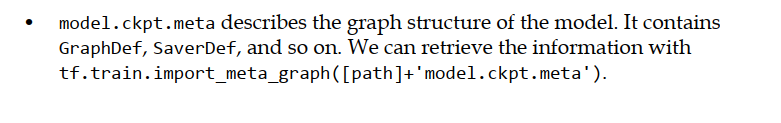

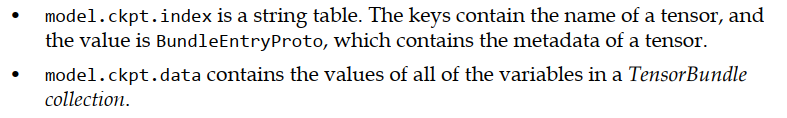

### Intermediate instructions

In [ ]:
!export PYTHONIOENCODING=UTF-8


In [ ]:
os.chdir("/content/gpt-2/src")


## Importing and defining the model

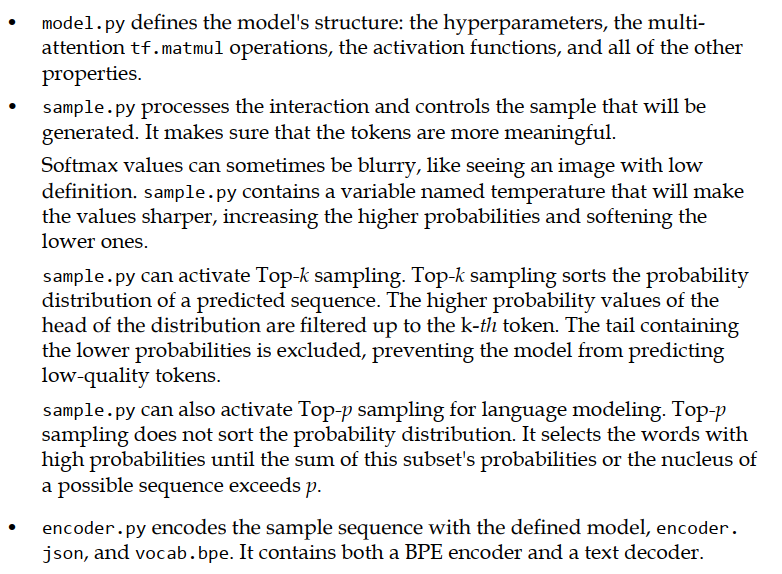

In [ ]:
import model, sample, encoder

In [ ]:
def interact_model(
    model_name,
    seed,
    nsamples,
    batch_size,
    length,
    temperature,
    top_k,
    models_dir
):
    models_dir = os.path.expanduser(os.path.expandvars(models_dir))
    if batch_size is None:
        batch_size = 1
    assert nsamples % batch_size == 0

    enc = encoder.get_encoder(model_name, models_dir)
    hparams = model.default_hparams()
    with open(os.path.join(models_dir, model_name, 'hparams.json')) as f:
        hparams.override_from_dict(json.load(f))

    if length is None:
        length = hparams.n_ctx // 2
    elif length > hparams.n_ctx:
        raise ValueError("Can't get samples longer than window size: %s" % hparams.n_ctx)

    with tf.Session(graph=tf.Graph()) as sess:
        context = tf.placeholder(tf.int32, [batch_size, None])
        np.random.seed(seed)
        tf.set_random_seed(seed)
        output = sample.sample_sequence(
            hparams=hparams, length=length,
            context=context,
            batch_size=batch_size,
            temperature=temperature, top_k=top_k
        )

        saver = tf.train.Saver()
        ckpt = tf.train.latest_checkpoint(os.path.join(models_dir, model_name))
        saver.restore(sess, ckpt)

        while True:
            raw_text = input("Model prompt >>> ")
            while not raw_text:
                print('Prompt should not be empty!')
                raw_text = input("Model prompt >>> ")
            context_tokens = enc.encode(raw_text)
            generated = 0
            for _ in range(nsamples // batch_size):
                out = sess.run(output, feed_dict={
                    context: [context_tokens for _ in range(batch_size)]
                })[:, len(context_tokens):]
                for i in range(batch_size):
                    generated += 1
                    text = enc.decode(out[i])
                    print("=" * 40 + " SAMPLE " + str(generated) + " " + "=" * 40)
                    print(text)
            print("=" * 80)

### Interacting with GPT-2

In [ ]:
interact_model('345M',None,1,1,300,1,0,'/content/gpt-2/models')






Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.random.categorical` instead.
INFO:tensorflow:Restoring parameters from /content/gpt-2/models/345M/model.ckpt
Model prompt >>> Human thinking involves human
======================================== SAMPLE 1 ========================================
 rituals like rubbing tinnitus together with deodorants, making ashtrays for normal smells, icing up cauldrons, etc. That stuff truly makes us smarter. This sense of "thinking more" is called "possibility," and it can be seen in experiments in cultural cortex cultures such as cultures of minorities in East Asia and Africa. POSSIBLE IS CHICKEN. Piksek ends his presented essay by noting that "some philosophers have gone so far as to call the act of thinking possible that it results in being teleologically primed by thinking. Thinking can create being, but it can als

KeyboardInterrupt: ignored

## Training a GPT-2 language model


###  Initial steps of the training process

In [ ]:
!git clone https://github.com/openai/gpt-2.git

Cloning into 'gpt-2'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 4.38 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
os.chdir("/content/gpt-2")
!pip3 install -r requirements.txt

In [ ]:
!python3 download_model.py '117M' #creates model directory


Fetching checkpoint: 1.00kit [00:00, 1.11Mit/s]                                                     
Fetching encoder.json: 1.04Mit [00:00, 3.17Mit/s]                                                   
Fetching hparams.json: 1.00kit [00:00, 1.09Mit/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:30, 16.3Mit/s]                                  
Fetching model.ckpt.index: 6.00kit [00:00, 5.73Mit/s]                                               
Fetching model.ckpt.meta: 472kit [00:00, 1.75Mit/s]                                                 
Fetching vocab.bpe: 457kit [00:00, 1.82Mit/s]                                                       


**We will copy the dataset and the 117M parameter GPT-2 model into the src
directory**

In [ ]:
!cp /content/dset.txt /content/gpt-2/src/
!cp -r /content/gpt-2/models/ /content/gpt-2/src/

In [ ]:
!cp /content/train.py /content/gpt-2/src/
!cp /content/load_dataset.py /content/gpt-2/src/
!cp /content/encode.py /content/gpt-2/src/
!cp /content/accumulate.py /content/gpt-2/src/
!cp /content/memory_saving_gradients.py /content/gpt-2/src/

In [ ]:
os.chdir("/content/gpt-2/src/")

In [ ]:
model_name="117M"

### Encode Dataset

In [ ]:
!python /content/gpt-2/src/encode.py dset.txt out.npz

Reading files
100% 1/1 [00:10<00:00, 10.83s/it]
Writing out.npz


### Train Model

In [ ]:
!python train.py --dataset out.npz

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




2021-07-12 23:22:35.462455: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-07-12 23:22:35.462672: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56208cbb92c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-12 23:22:35.462706: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-07-12 23:22:35.465405: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-12 23:22:35.710348: I tensorflow/stream_executo

### Creating a Training Model directory and Copying training Files

In [ ]:
run_dir = '/content/gpt-2/models/tgmodel'
if not os.path.exists(run_dir):
  os.makedirs(run_dir)

In [ ]:
!cp /content/gpt-2/src/checkpoint/run1/model-1000.data-00000-of-00001 /content/gpt-2/models/tgmodel
!cp /content/gpt-2/src/checkpoint/run1/checkpoint /content/gpt-2/models/tgmodel
!cp /content/gpt-2/src/checkpoint/run1/model-1000.index /content/gpt-2/models/tgmodel
!cp /content/gpt-2/src/checkpoint/run1/model-1000.meta /content/gpt-2/models/tgmodel
!cp /content/gpt-2/models/117M/encoder.json /content/gpt-2/models/tgmodel
!cp /content/gpt-2/models/117M/hparams.json /content/gpt-2/models/tgmodel
!cp /content/gpt-2/models/117M/vocab.bpe /content/gpt-2/models/tgmodel
# Renaming the model directories
!mv /content/gpt-2/models/117M  /content/gpt-2/models/117M_OpenAI
!mv /content/gpt-2/models/tgmodel  /content/gpt-2/models/117M


### Generating Unconditional Samples

In [ ]:
os.chdir("/content/gpt-2/src")
!python generate_unconditional_samples.py --model_name '117M'


2021-07-12 23:41:06.577509: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-12 23:41:06.582996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-12 23:41:06.583516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-07-12 23:41:06.583826: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-07-12 23:41:06.585375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-12 23:41:06.586932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021

### Interactive Context and Completion Examples

In [ ]:
os.chdir("/content/gpt-2/src")
!python interactive_conditional_samples.py --temperature 0.8 --top_k 40 --model_name '117M'


2021-07-12 23:42:15.039855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-12 23:42:15.045447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-12 23:42:15.045955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-07-12 23:42:15.046325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-07-12 23:42:15.048129: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-12 23:42:15.049789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021

# **Text Summarization [T5 Model]**
Humans learn a language and then apply that knowledge to a wide range of NLP
tasks through transfer learning. The core concept of a T5 model is to find an abstract
model that can do things like us.

**A prefix instead of task-specific formats**

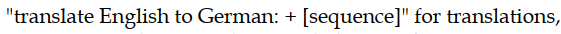
image.png
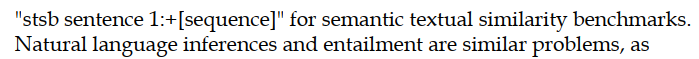
image.png

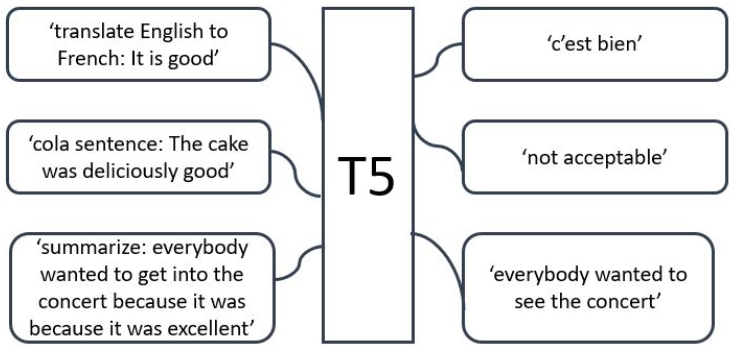

**The unification process makes it possible to use the same model, hyperparameters,
and optimizer for a wide range of tasks.**

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-large')
tokenizer = T5Tokenizer.from_pretrained('t5-large')

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='t5-large', vocab_size=32100, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>'

In [ ]:
def summarize(text,ml):
  preprocess_text = text.strip().replace("\n","")
  t5_prepared_Text = "summarize: "+preprocess_text
  print ("Preprocessed and prepared text: \n", t5_prepared_Text)

  tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt")

  # summmarize 
  summary_ids = model.generate(tokenized_text,
                                      num_beams=4,
                                      no_repeat_ngram_size=2,
                                      min_length=30,
                                      max_length=ml,
                                      early_stopping=True)

  output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  return output

In [ ]:
text="""
The United States Declaration of Independence was the first Etext
released by Project Gutenberg, early in 1971.  The title was stored
in an emailed instruction set which required a tape or diskpack be
hand mounted for retrieval.  The diskpack was the size of a large
cake in a cake carrier, cost $1500, and contained 5 megabytes, of
which this file took 1-2%.  Two tape backups were kept plus one on
paper tape.  The 10,000 files we hope to have online by the end of
2001 should take about 1-2% of a comparably priced drive in 2001.
"""
print("Number of characters:",len(text))
summary=summarize(text,50)
print ("\n\nSummarized text: \n",summary)

Number of characters: 534
Preprocessed and prepared text: 
 summarize: The United States Declaration of Independence was the first Etextreleased by Project Gutenberg, early in 1971.  The title was storedin an emailed instruction set which required a tape or diskpack behand mounted for retrieval.  The diskpack was the size of a largecake in a cake carrier, cost $1500, and contained 5 megabytes, ofwhich this file took 1-2%.  Two tape backups were kept plus one onpaper tape.  The 10,000 files we hope to have online by the end of2001 should take about 1-2% of a comparably priced drive in 2001.


Summarized text: 
 the united states declaration of independence was the first etext published by project gutenberg, early in 1971. the 10,000 files we hope to have online by the end of2001 should take about 1-2% of a comparably priced drive in


# **Matching Tokenizers and Datasets**

- we will go through some of the limits of tokenizers that hinder
the quality of downstream transformer tasks. Do not take pretrained tokenizers at
face value. You might have a specific dictionary of words you are using (advanced
medical language, for example) with words that are not processed by a generic
pretrained tokenizer.

- We will start by introducing some tokenizer-agnostic best practices to measure the
quality of a tokenizer. We will describe basic guidelines for datasets and tokenizers
from a tokenization perspective

- we will see the limits of tokenizers with a word2vector tokenizer to describe
the problems we face with any tokenizing method. The limits will be illustrated with
a Python progam

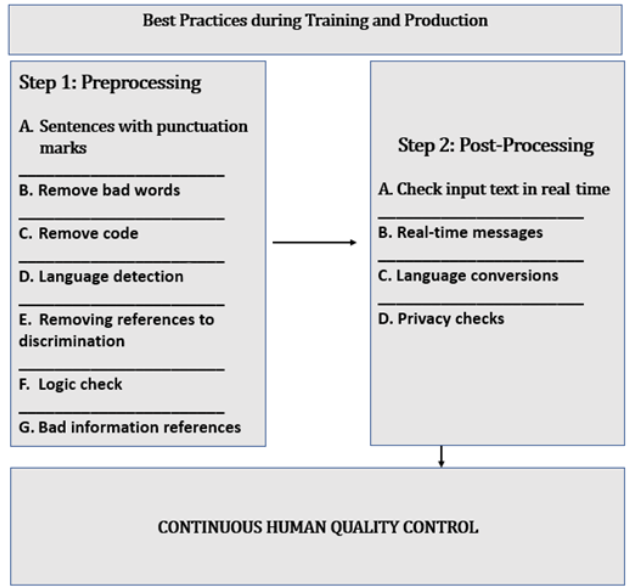

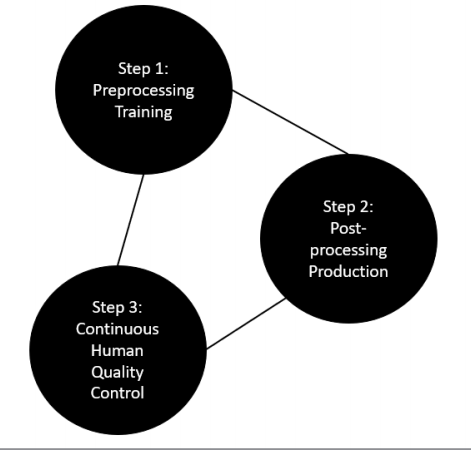

## Word2Vec Tokenizer

In [ ]:

#@title Word2Vec Tokenization
#‘text.txt’ file 
sample = open("kant.txt", "r") 
s = sample.read() 

# processing escape characters 
f = s.replace("\n", " ") 

data = [] 
# sentence parsing
for i in sent_tokenize(f): 
	temp = [] 
	# tokenize the sentence into words 
	for j in word_tokenize(i): 
		temp.append(j.lower())
	data.append(temp)

# Creating Skip Gram model 
model2 = gensim.models.Word2Vec(data, min_count = 1, size = 512,window = 5, sg = 1) 
print(model2)

Word2Vec(vocab=10255, size=512, alpha=0.025)


In [ ]:
def similarity(word1,word2):
        cosine=False #default value
        try:
                a=model2[word1]
                cosine=True
        except KeyError:     #The KeyError exception is raised
                print(word1, ":[unk] key not found in dictionary")#False implied

        try:
                b=model2[word2]#a=True implied
        except KeyError:       #The KeyError exception is raised
                cosine=False   #both a and b must be true
                print(word2, ":[unk] key not found in dictionary")

        if(cosine==True):
                b=model2[word2]
                # compute cosine similarity
                dot = np.dot(a, b)
                norma = np.linalg.norm(a)
                normb = np.linalg.norm(b)
                cos = dot / (norma * normb)

                aa = a.reshape(1,512) 
                ba = b.reshape(1,512)
                #print("Word1",aa)
                #print("Word2",ba)
                cos_lib = cosine_similarity(aa, ba)
                #print(cos_lib,"word similarity")
          
        if(cosine==False):cos_lib=0;
        return cos_lib

### Test Similarity

In [ ]:
word1="freedom";word2="liberty"
print("Similarity",similarity(word1,word2),word1,word2)

Similarity [[0.3785063]] freedom liberty


### Case 1: Words not in the dataset or the dictionary


In [ ]:
word1="corporations";word2="rights"
print("Similarity",similarity(word1,word2),word1,word2)

corporations :[unk] key not found in dictionary
Similarity 0 corporations rights


Dead end! The word is an unknown [unk] token.
The missing word will provoke a chain of events and problems that will distort the
transformer model's output if the word was important. We will refer to the missing
word as unk.

Several possibilities need to be checked, and questions answered:

• unk was in the dataset but was not selected to be in the tokenized dictionary.

• unk was not in the dataset, which is the case for the word "corporations".

This explains why it's not in the dictionary in this case.

• unk will now appear in production if a user sends an input to the transformer
that contains the token and it is not tokenized.

• unk was not an important word for the dataset but is for the usage of the
transformer.


The list of problems will continue to grow if the transformer produces terrible results
in some cases. We can consider 0.8 as excellent performance for a transformer model
for a specific downstream task during the training phase. But in real life, who wants
to work with a system that's wrong 20% of the time:

• A doctor?
• A lawyer?
• A nuclear plant maintenance team?

0.8 is satisfactory in a fuzzy environment like social media in which many of the
messages lack proper language structure anyway.

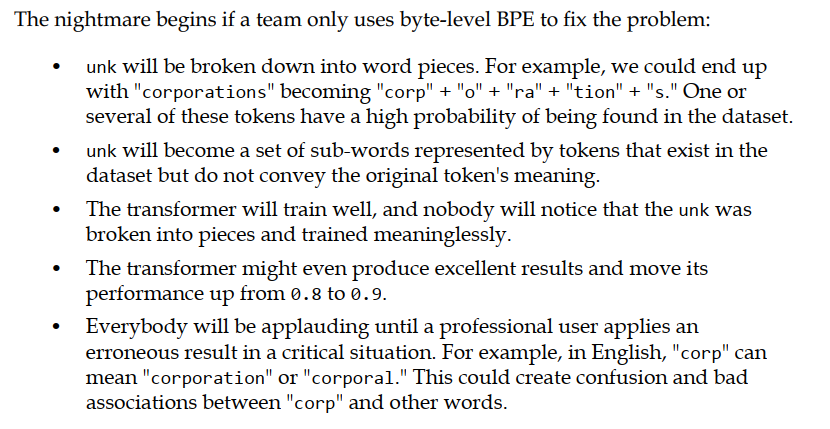

### Case 2: Noisy relationships


In [ ]:
word1="etext";word2="declaration"
print("Similarity",similarity(word1,word2),word1,word2)

etext :[unk] key not found in dictionary
Similarity 0 etext declaration


### Case 3: Rare words


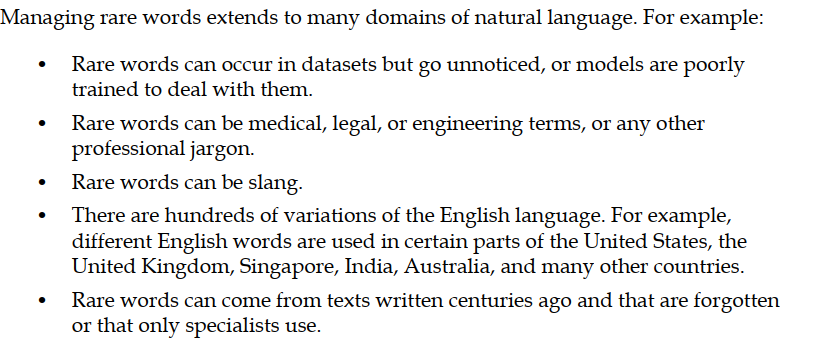

In [ ]:
word1="justiciar";word2="judgement"
print("Similarity",similarity(word1,word2),word1,word2)

justiciar :[unk] key not found in dictionary
Similarity 0 justiciar judgement


### Case 4: Replacing rare words


In [ ]:
word1="judge";word2="judgement"
print("Similarity",similarity(word1,word2),word1,word2)

Similarity [[0.17129734]] judge judgement


In [ ]:
word1="justiciar";word2="judge"
print("Similarity",similarity(word1,word2),word1,word2)

justiciar :[unk] key not found in dictionary
Similarity 0 justiciar judge


### Case 5: Entailment

In [ ]:
word1="pay";word2="debt"
print("Similarity",similarity(word1,word2),word1,word2)

Similarity [[0.39237785]] pay debt


# Semantic Role Labeling with BERT-Based Transformers
the idea that we can find who did what,
and where, without depending on lexical or syntactic features.

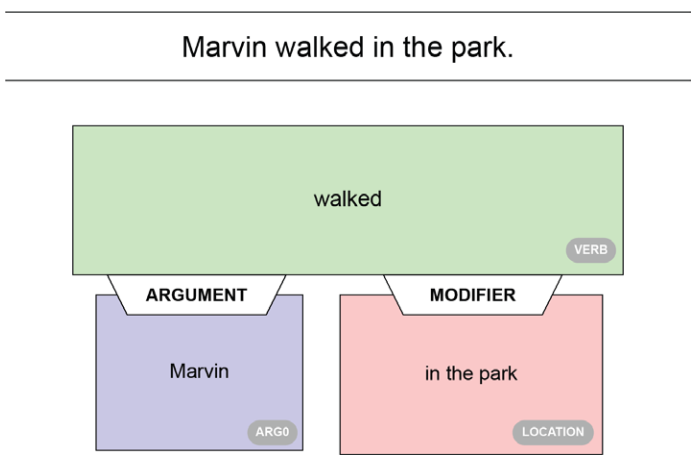


• VERB: The predicate of the sentence.

• ARGUMENT: An argument of the sentence named ARG0.

• MODIFIER: A modifier of the sentence. In this case, a LOCATION. It could
have been an adverb, an adjective, or anything that modifies the predicate's
meaning.

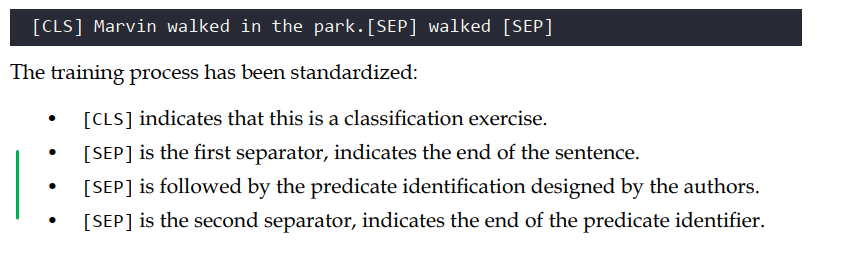

In [ ]:
!echo '{"sentence": "Did Bob really think he could prepare a meal for 50 people in only a few hours?"}' | \
allennlp predict https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.03.24.tar.gz -

2021-07-13 22:04:40,264 - INFO - transformers.file_utils - PyTorch version 1.5.1 available.
2021-07-13 22:04:40.524027: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-13 22:04:42,085 - INFO - transformers.file_utils - TensorFlow version 2.5.0 available.
2021-07-13 22:04:43,393 - INFO - allennlp.common.file_utils - checking cache for https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.03.24.tar.gz at /root/.allennlp/cache/e20d5b792a8d456a1a61da245d1856d4b7778efe69ac3c30759af61940aa0f42.f72523a9682cb1f5ad3ecf834075fe53a1c25a6bcbf4b40c11e13b7f426a4724
2021-07-13 22:04:43,393 - INFO - allennlp.common.file_utils - waiting to acquire lock on /root/.allennlp/cache/e20d5b792a8d456a1a61da245d1856d4b7778efe69ac3c30759af61940aa0f42.f72523a9682cb1f5ad3ecf834075fe53a1c25a6bcbf4b40c11e13b7f426a4724
2021-07-13 22:04:43,394 - INFO - filelock - Lock 140384420622160 acquired on /root/.allennlp/cache/e20d5

# Questioning Answer

In [ ]:
nlp_qa = pipeline('question-answering')


In [ ]:
sequence = "The traffic began to slow down on Pioneer Boulevard in Los Angeles, making it difficult to get out of the city. However, WBGO was playing some cool jazz, and the weather was cool, making it rather pleasant to be making it out of the city on this Friday afternoon. Nat King Cole was singing as Jo and Maria slowly made their way out of LA and drove toward Barstow. They planned to get to Las Vegas early enough in the evening to have a nice dinner and go see a show."


In [ ]:
nlp_qa(context=sequence, question='Where is Pioneer Boulevard ?')


{'answer': 'Los Angeles', 'end': 66, 'score': 0.9879737496376038, 'start': 55}

In [ ]:
nlp_ner = pipeline("ner")
print(nlp_ner(sequence))


[{'entity': 'I-LOC', 'score': 0.97352576, 'index': 8, 'word': 'Pioneer', 'start': 34, 'end': 41}, {'entity': 'I-LOC', 'score': 0.99448246, 'index': 9, 'word': 'Boulevard', 'start': 42, 'end': 51}, {'entity': 'I-LOC', 'score': 0.9995776, 'index': 11, 'word': 'Los', 'start': 55, 'end': 58}, {'entity': 'I-LOC', 'score': 0.99956936, 'index': 12, 'word': 'Angeles', 'start': 59, 'end': 66}, {'entity': 'I-ORG', 'score': 0.9919845, 'index': 26, 'word': 'W', 'start': 121, 'end': 122}, {'entity': 'I-ORG', 'score': 0.99075025, 'index': 27, 'word': '##B', 'start': 122, 'end': 123}, {'entity': 'I-ORG', 'score': 0.9884582, 'index': 28, 'word': '##G', 'start': 123, 'end': 124}, {'entity': 'I-ORG', 'score': 0.9722683, 'index': 29, 'word': '##O', 'start': 124, 'end': 125}, {'entity': 'I-PER', 'score': 0.9966881, 'index': 59, 'word': 'Nat', 'start': 264, 'end': 267}, {'entity': 'I-PER', 'score': 0.9976483, 'index': 60, 'word': 'King', 'start': 268, 'end': 272}, {'entity': 'I-PER', 'score': 0.99861705, 

In [ ]:
nlp_qa = pipeline('question-answering')
print("Question 1.",nlp_qa(context=sequence, question='Where is Pioneer Boulevard ?'))
print("Question 2.",nlp_qa(context=sequence, question='Where is Los Angeles located?'))
print("Question 3.",nlp_qa(context=sequence, question='Where is LA ?'))
print("Question 4.",nlp_qa(context=sequence, question='Where is Barstow ?'))
print("Question 5.",nlp_qa(context=sequence, question='Where is Las Vegas located ?'))

Question 1. {'score': 0.9879737496376038, 'start': 55, 'end': 66, 'answer': 'Los Angeles'}
Question 2. {'score': 0.9875388741493225, 'start': 34, 'end': 51, 'answer': 'Pioneer Boulevard'}
Question 3. {'score': 0.5090540647506714, 'start': 55, 'end': 66, 'answer': 'Los Angeles'}
Question 4. {'score': 0.3695431649684906, 'start': 387, 'end': 396, 'answer': 'Las Vegas'}
Question 5. {'score': 0.21839778125286102, 'start': 355, 'end': 362, 'answer': 'Barstow'}


In [ ]:
nlp_qa = pipeline('question-answering')
nlp_qa(context=sequence, question='Who was singing ?')

{'answer': 'Nat King Cole',
 'end': 277,
 'score': 0.9653680324554443,
 'start': 264}

## Question-Answering with ELECTRA



In [ ]:
nlp_qa = pipeline('question-answering', model='google/electra-small-generator', tokenizer='google/electra-small-generator')
nlp_qa(context=sequence, question='Who drove to Las Vegas ?')

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForQuestionAnswering: ['generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-small-generator and are newly initialized: ['qa_outputs.bia

{'answer': 'pleasant to be making it out of the city on this Friday',
 'end': 252,
 'score': 0.00041368993697687984,
 'start': 197}

In [ ]:

nlp_qa = pipeline('question-answering')
nlp_qa(context=sequence, question='What was slow?')

{'answer': 'The traffic', 'end': 11, 'score': 0.46530455350875854, 'start': 0}

## Haystack 

In [ ]:
# Install Haystack
!pip install farm-haystack==0.6.0

# Install specific versions of urllib and torch to avoid conflicts with preinstalled versions on Colab
!pip install urllib3==1.25.4
!pip install torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 112kB 26.2MB/s 
     |████████████████████████████████| 348kB 42.1MB/s 
     |████████████████████████████████| 215kB 39.7MB/s 
     |████████████████████████████████| 983kB 53.6MB/s 
     |████████████████████████████████| 3.8MB 55.4MB/s 
     |████████████████████████████████| 3.4MB 54.0MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 5.6MB 37.1MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 7.2MB 25.8MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 337kB 53.5MB/s 
     |████████████████████████████████| 327kB 56.1MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 47.7MB 56kB/s 
     |████████████████████████████████| 1.1MB 49.4MB/s 
     |████████████████████████████████| 327kB 59.0MB/s 

     |████████████████████████████████| 133kB 36.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.3.1 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: allennlp 1.0.0 has requirement torch<1.6.0,>=1.5.0, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.3.1 which is incompatible.
  Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1


In [ ]:
# Load a  local model or any of the QA models on Hugging Face's model hub (https://huggingface.co/models)
from haystack.reader.farm import FARMReader

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True, no_ans_boost=0, return_no_answer=False)


# Create document which the model should scan for answers.
from haystack import Document

text = "The traffic began to slow down on Pioneer Boulevard in Los Angeles, making it difficult to get out of the city. However, WBGO was playing some cool jazz, and the weather was cool, making it rather pleasant to be making it out of the city on this Friday afternoon. Nat King Cole was singing as Jo and Maria slowly made their way out of LA and drove toward Barstow. They planned to get to Las Vegas early enough in the evening to have a nice dinner and go see a show."
doc = Document(text=text)

ImportError: ignored

In [ ]:
reader.predict(query="Where is Pioneer Boulevard located?", documents=[doc])


In [ ]:
reader.predict(query="Who drove to Las Vegas?", documents=[doc])


In [ ]:
reader.predict(query="Who is singing?", documents=[doc])


# **Detecting Customer Emotions to Make Predictions**

Sentiment analysis relies on the principle of compositionality. If we cannot
understand parts of a sentence, how can we understand a whole sentence? Is this
tough task possible for NLP transformer models? We will try several transformer
models in this chapter to find out.
We will start with the Stanford Sentiment Treebank (SST). The SST provides
datasets with complex sentences to analyze. It is easy to analyze sentences such as
"The movie was great." What happens if the task becomes very tough with complex
sentences such as "Although the movie was a bit too long, I really enjoyed
it."? This sentence is segmented. It forces a transformer model to understand not
only the structure of the sequence but also its logical form.

In [ ]:
!echo '{"sentence": "Whether or not you're enlightened by any of Derrida's lectures on the other and the self, Derrida is an undeniably fascinating and playful fellow."}' | \
allennlp predict https://storage.googleapis.com/allennlp-public-models/sst-roberta-large-2020.06.08.tar.gz -

2021-07-13 22:13:34.698618: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-13 22:13:37,271 - INFO - faiss - Loading faiss with AVX2 support.
2021-07-13 22:13:37,272 - INFO - faiss - Loading faiss.
2021-07-13 22:13:39,249 - INFO - allennlp.common.file_utils - checking cache for https://storage.googleapis.com/allennlp-public-models/sst-roberta-large-2020.06.08.tar.gz at /root/.allennlp/cache/8255466347f7b3a13b6bf71883dca4a02eefc30ce15004b8b41ba231b0e3de6d.f4aa9e5021ce7bf3c17488c8924b4aad654883a2f0b65528127695344bb741ac
2021-07-13 22:13:39,249 - INFO - allennlp.common.file_utils - waiting to acquire lock on /root/.allennlp/cache/8255466347f7b3a13b6bf71883dca4a02eefc30ce15004b8b41ba231b0e3de6d.f4aa9e5021ce7bf3c17488c8924b4aad654883a2f0b65528127695344bb741ac
2021-07-13 22:13:39,250 - INFO - filelock - Lock 140071632807120 acquired on /root/.allennlp/cache/8255466347f7b3a13b6bf71883dca4a02eefc30ce15004b8b41ba231b0

### **DistilBERT**

In [ ]:
def classify(sequence,M):
   #DistilBertForSequenceClassification(default model)
    nlp_cls = pipeline('sentiment-analysis') 
    if M==1:
      print(nlp_cls.model.config)
    return nlp_cls(sequence)

In [ ]:
sequence="The battery on my Model9X phone doesn't last more than 6 hours and I'm unhappy about that. I was really mad! I bought a Moel10x and things seem to be better. I'm super satisfied now."
CS=classify(sequence,0) 
print(CS)

07/13/2021 22:15:10 - INFO - filelock -   Lock 140487425953680 acquired on /root/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b.lock


07/13/2021 22:15:10 - INFO - filelock -   Lock 140487425953680 released on /root/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b.lock
07/13/2021 22:15:11 - INFO - filelock -   Lock 140487427640528 acquired on /root/.cache/huggingface/transformers/8d04c767d9d4c14d929ce7ad8e067b80c74dbdb212ef4c3fb743db4ee109fae0.9d268a35da669ead745c44d369dc9948b408da5010c6bac414414a7e33d5748c.lock


07/13/2021 22:15:16 - INFO - filelock -   Lock 140487427640528 released on /root/.cache/huggingface/transformers/8d04c767d9d4c14d929ce7ad8e067b80c74dbdb212ef4c3fb743db4ee109fae0.9d268a35da669ead745c44d369dc9948b408da5010c6bac414414a7e33d5748c.lock


07/13/2021 22:15:17 - INFO - filelock -   Lock 140487424609872 acquired on /root/.cache/huggingface/transformers/d44ec0488a5f13d92b3934cb68cc5849bd74ce63ede2eea2bf3c675e1e57297c.627f9558061e7bc67ed0f516b2f7efc1351772cc8553101f08748d44aada8b11.lock


07/13/2021 22:15:17 - INFO - filelock -   Lock 140487424609872 released on /root/.cache/huggingface/transformers/d44ec0488a5f13d92b3934cb68cc5849bd74ce63ede2eea2bf3c675e1e57297c.627f9558061e7bc67ed0f516b2f7efc1351772cc8553101f08748d44aada8b11.lock
07/13/2021 22:15:17 - INFO - filelock -   Lock 140487423378448 acquired on /root/.cache/huggingface/transformers/83261b0c74c462e53d6367de0646b1fca07d0f15f1be045156b9cf8c71279cc9.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


07/13/2021 22:15:17 - INFO - filelock -   Lock 140487423378448 released on /root/.cache/huggingface/transformers/83261b0c74c462e53d6367de0646b1fca07d0f15f1be045156b9cf8c71279cc9.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock



[{'label': 'NEGATIVE', 'score': 0.8346410393714905}]
